In [1]:
%pip install gymnasium flappy-bird-gymnasium stable-baselines3 shimmy moviepy tensorboard pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import gymnasium as gym
import flappy_bird_gymnasium
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import pandas as pd
import os
import time
import random
import numpy as np
import torch

# kaggle
os.environ["SDL_VIDEODRIVER"] = "dummy"

# --- CONFIGURAÇÕES GERAIS ---
SEED = 42
TIMESTEPS = 200000        # Quantidade de passos de treino (aprox 20-30 min por modelo)
N_EVAL_EPISODES = 100      # Jogos de teste para calcular a média final
MAX_EPISODE_STEPS = 4000  # Limite de passos por episódio para evitar loops infinitos
LOG_DIR = "./relatorio_logs"
MODEL_DIR = "./relatorio_models"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# --- DEFINIÇÃO DOS EXPERIMENTOS ---
# Aqui definimos o "Cardápio" de testes para o relatório.
experimentos = [
{
        "id": "3_PPO_LearningRate",
        "algo": PPO,
        "descricao": "PPO com arquitetura 64x64, mas Learning Rate reduzido (0.0001) para maior estabilidade.",
        "params": {
            "policy": "MlpPolicy",
            "learning_rate": 0.0001,  # Original era 0.0003. Menor = aprendizado mais suave.
            "gamma": 0.99
        }
    },
{
        "id": "4_PPO_Entropy",
        "algo": PPO,
        "descricao": "PPO Padrão com coeficiente de entropia (0.01) para forçar exploração de novas rotas.",
        "params": {
            "policy": "MlpPolicy",
            "learning_rate": 0.0003,
            "ent_coef": 0.01,         # O padrão é 0.0. Isso força o agente a não ser "viciado" em uma só ação.
            "gamma": 0.99
        }
    },
{
        "id": "2_DQN",
        "algo": DQN,
        "descricao": "DQN com Target Network lenta e Buffer cheio antes de começar.",
        "params": {
            "policy": "MlpPolicy",
            "learning_rate": 0.0001,      # Reduzido para evitar divergência
            "buffer_size": 50000,
            "learning_starts": 10000,     # Aumentado: só treina depois de ver 10k frames (antes era 1k)
            "batch_size": 128,
            "train_freq": 4,
            "gradient_steps": 1,
            "target_update_interval": 2000, # Aumentado MUITO (antes 250). Dá estabilidade ao alvo.
            "exploration_fraction": 0.5,   # Explora por 50% do treino (antes 20%)
            "exploration_final_eps": 0.05
        }
    }
]


In [3]:
import shutil
import os

def limpar_pasta(caminho):
    if os.path.exists(caminho):
        shutil.rmtree(caminho)  # Deleta a pasta e tudo dentro
        print(f"Pasta limpa: {caminho}")
    os.makedirs(caminho, exist_ok=True) # Cria a pasta vazia novamente

limpar_pasta(LOG_DIR)
limpar_pasta(MODEL_DIR)

Pasta limpa: ./relatorio_logs
Pasta limpa: ./relatorio_models


In [4]:
# --- Célula Extra: Imprimir Configurações para o Relatório ---
print("=== DADOS PARA A TABELA DE METODOLOGIA ===")
for exp in experimentos:
    print(f"\nExperimento: {exp['id']}")
    print(f"  - Algoritmo: {exp['algo'].__name__}")
    print(f"  - Policy: {exp['params']['policy']}")
    # Imprime todos os params extras
    for k, v in exp['params'].items():
        if k != 'policy':
            print(f"  - {k}: {v}")

=== DADOS PARA A TABELA DE METODOLOGIA ===

Experimento: 3_PPO_LearningRate
  - Algoritmo: PPO
  - Policy: MlpPolicy
  - learning_rate: 0.0001
  - gamma: 0.99

Experimento: 4_PPO_Entropy
  - Algoritmo: PPO
  - Policy: MlpPolicy
  - learning_rate: 0.0003
  - ent_coef: 0.01
  - gamma: 0.99

Experimento: 2_DQN
  - Algoritmo: DQN
  - Policy: MlpPolicy
  - learning_rate: 0.0001
  - buffer_size: 50000
  - learning_starts: 10000
  - batch_size: 128
  - train_freq: 4
  - gradient_steps: 1
  - target_update_interval: 2000
  - exploration_fraction: 0.5
  - exploration_final_eps: 0.05


In [5]:
import pandas as pd

print("--- SALVANDO CONFIGURAÇÕES DOS EXPERIMENTOS ---")

dados_params = []

for exp in experimentos:
    # 1. Cria um dicionário base com ID e Descrição
    linha = {
        "Experimento": exp["id"],
        "Algoritmo": exp["algo"].__name__,
        "Descricao": exp["descricao"]
    }
    
    # 2. Adiciona todos os parâmetros do modelo (learning_rate, gamma, etc.)
    # O método .update() mescla os dicionários
    linha.update(exp["params"])
    
    # 3. Tratamento especial para 'policy_kwargs' (dicionários dentro de dicionários)
    # Se não converter para string, pode quebrar o CSV ou ficar ilegível
    if "policy_kwargs" in linha:
        linha["policy_kwargs"] = str(linha["policy_kwargs"])
        
    dados_params.append(linha)

# 4. Cria o DataFrame e salva
df_params = pd.DataFrame(dados_params)

# Reorganiza as colunas para "Experimento" ser a primeira, se possível
cols = ["Experimento", "Algoritmo"] + [c for c in df_params.columns if c not in ["Experimento", "Algoritmo"]]
df_params = df_params[cols]

# Salva em CSV
nome_arquivo_params = "parametros_experimentos.csv"
df_params.to_csv(nome_arquivo_params, index=False)

print(f"Arquivo '{nome_arquivo_params}' salvo com sucesso!")
print("Exibindo prévia:")
display(df_params)

--- SALVANDO CONFIGURAÇÕES DOS EXPERIMENTOS ---
Arquivo 'parametros_experimentos.csv' salvo com sucesso!
Exibindo prévia:


,Experimento,Algoritmo,Descricao,policy,learning_rate,gamma,ent_coef,buffer_size,learning_starts,batch_size,train_freq,gradient_steps,target_update_interval,exploration_fraction,exploration_final_eps
0,3_PPO_LearningRate,PPO,"PPO com arquitetura 64x64, mas Learning Rate r...",MlpPolicy,0.0001,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4_PPO_Entropy,PPO,PPO Padrão com coeficiente de entropia (0.01) ...,MlpPolicy,0.0003,0.99,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2_DQN,DQN,DQN com Target Network lenta e Buffer cheio an...,MlpPolicy,0.0001,NaN,NaN,50000.0,10000.0,128.0,4.0,1.0,2000.0,0.5,0.05


In [ ]:

from gymnasium.wrappers import TimeLimit
resultados_finais = []

print(f"--- INICIANDO BATERIA DE {len(experimentos)} EXPERIMENTOS ---")
print(f"Passos por experimento: {TIMESTEPS}")

inicio_total = time.time()

for exp in experimentos:
    nome = exp["id"]
    AlgoClass = exp["algo"]
    print(f"\n> [INICIANDO] Experimento: {nome}")
    print(f"  Descrição: {exp['descricao']}")

    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # 1. Cria o ambiente (use_lidar=True para usar sensores numéricos -> MlpPolicy)
    env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=True)
    
    env = TimeLimit(env, max_episode_steps=MAX_EPISODE_STEPS)
    
    env.reset(seed=SEED)
    env.action_space.seed(SEED)

    # 2. Inicializa o modelo
    model = AlgoClass(env=env, verbose=0, tensorboard_log=LOG_DIR, seed=SEED, **exp["params"])

    # 3. Treina (com medidor de tempo)
    start_time = time.time()
    model.learn(total_timesteps=TIMESTEPS, tb_log_name=nome)
    tempo_treino = time.time() - start_time

    # 4. Salva o modelo treinado
    caminho_salvo = f"{MODEL_DIR}/{nome}"
    model.save(caminho_salvo)
    print(f"  Treino finalizado em {tempo_treino:.1f} segundos.")

    # 5. Avaliação Final (Gera os números para a Tabela do Relatório)
    print("  Avaliando desempenho...")
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=N_EVAL_EPISODES)

    score_seguro = mean_reward - (0.5 * std_reward)
    
    # 6. Registra os dados
    resultados_finais.append({
        "Experimento": nome,
        "Algoritmo": AlgoClass.__name__,
        "Recompensa Média": round(mean_reward, 2),
        "Desvio Padrão": round(std_reward, 2),
        "Score Seguro": round(score_seguro, 2),
        "Tempo de Treino (s)": round(tempo_treino, 1)
    })

    env.close()

tempo_total = time.time() - inicio_total
print(f"\n--- TODOS OS EXPERIMENTOS CONCLUÍDOS ({tempo_total/60:.1f} min) ---")

# --- EXPORTAR RESULTADOS ---
df = pd.DataFrame(resultados_finais)

df = df.sort_values(by="Score Seguro", ascending=False)

print("\n=== TABELA PARA O RELATÓRIO ===")
print(df)

# Salva em CSV para você abrir no Excel se precisar
df.to_csv("resultados_finais_relatorio.csv", index=False)
print("\nArquivo 'resultados_finais_relatorio.csv' salvo com sucesso.")
print(f"Para ver os gráficos: execute 'tensorboard --logdir={LOG_DIR}' no terminal.")

--- INICIANDO BATERIA DE 3 EXPERIMENTOS ---
Passos por experimento: 200000

> [INICIANDO] Experimento: 3_PPO_LearningRate
  Descrição: PPO com arquitetura 64x64, mas Learning Rate reduzido (0.0001) para maior estabilidade.


c:\Users\neope\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\neope\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
c:\Users\neope\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:158: Use

In [ ]:
# Nao descomentar no colab nem kaggle
# import gymnasium as gym
# import flappy_bird_gymnasium
# from stable_baselines3 import PPO, DQN
# import os

# # CONFIGURAÇÃO
# # Troque pelo nome exato do arquivo gerado na pasta 'relatorio_models'
# NOME_MODELO = "1_PPO_Padrao"
# ALGORITMO = PPO # Se for carregar o DQN, mude para: ALGORITMO = DQN

# modelo_path = f"relatorio_models/{NOME_MODELO}.zip"

# if not os.path.exists(modelo_path):
#     print(f"Erro: Arquivo {modelo_path} não encontrado.")
#     exit()

# # Cria ambiente com renderização para HUMANOS
# env = gym.make("FlappyBird-v0", render_mode="human", use_lidar=True)

# print(f"Carregando {NOME_MODELO}...")
# model = ALGORITMO.load(modelo_path)

# obs, _ = env.reset()
# print("Pressione CTRL+C no terminal para parar.")

# try:
#     while True:
#         # O modelo prevê a ação
#         action, _ = model.predict(obs, deterministic=True)
#         # O ambiente executa
#         obs, reward, done, trunc, info = env.step(action)

#         if done or trunc:
#             obs, _ = env.reset()

# except KeyboardInterrupt:
#     print("Encerrando visualização.")
#     env.close()

In [ ]:
# 1. Carrega a extensão do Tensorboard
%load_ext tensorboard

# 2. Inicia o Tensorboard apontando para a pasta de logs
# a pasta é './relatorio_logs'
%tensorboard --logdir ./relatorio_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25364), started 2:04:19 ago. (Use '!kill 25364' to kill it.)

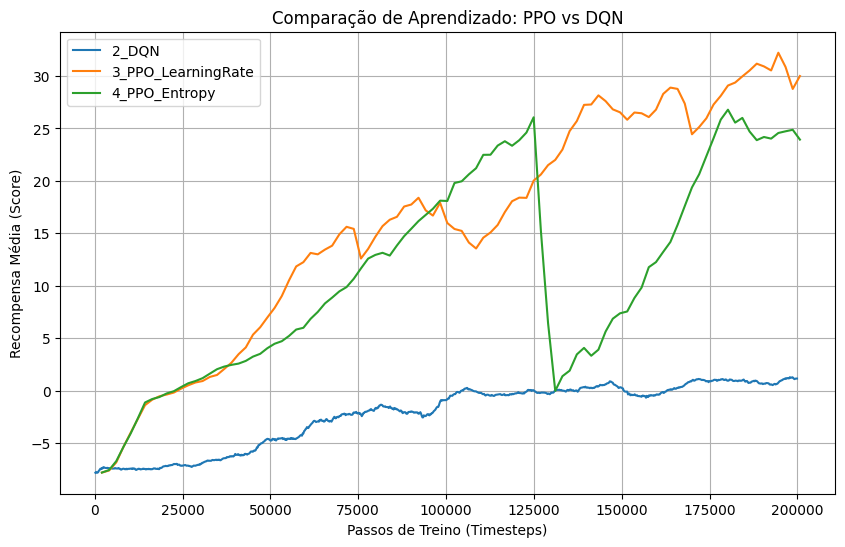

Gráfico salvo como 'grafico_comparativo.png'. Baixe na aba de arquivos à esquerda!


In [ ]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

# Configuração
log_dir = "./relatorio_logs"

def ler_dados_tensorboard(caminho_pasta):
    # Encontra o arquivo de eventos dentro da pasta
    arquivos = [f for f in os.listdir(caminho_pasta) if "tfevents" in f]
    if not arquivos:
        return None, None

    caminho_arquivo = os.path.join(caminho_pasta, arquivos[0])
    ea = EventAccumulator(caminho_arquivo)
    ea.Reload()

    # Extrai recompensas (geralmente a tag é 'rollout/ep_rew_mean')
    tags = ea.Tags()['scalars']
    if 'rollout/ep_rew_mean' in tags:
        eventos = ea.Scalars('rollout/ep_rew_mean')
        steps = [x.step for x in eventos]
        rewards = [x.value for x in eventos]
        return steps, rewards
    return None, None

plt.figure(figsize=(10, 6))

# Varre as pastas de logs (1_PPO_Padrao, 2_DQN_Padrao, etc)
for pasta_modelo in os.listdir(log_dir):
    caminho_completo = os.path.join(log_dir, pasta_modelo)
    if os.path.isdir(caminho_completo):
        steps, rewards = ler_dados_tensorboard(caminho_completo)
        if steps:
            plt.plot(steps, rewards, label=pasta_modelo)

plt.title("Comparação de Aprendizado: PPO vs DQN")
plt.xlabel("Passos de Treino (Timesteps)")
plt.ylabel("Recompensa Média (Score)")
plt.legend()
plt.grid(True)
plt.savefig("grafico_comparativo.png")
plt.show()

print("Gráfico salvo como 'grafico_comparativo.png'. Baixe na aba de arquivos à esquerda!")

In [ ]:
import gymnasium as gym
import flappy_bird_gymnasium
from stable_baselines3 import PPO, DQN
from gymnasium.wrappers import RecordVideo
import os
import pandas as pd

# --- GRAVAÇÃO AUTOMÁTICA DO MELHOR AGENTE ---

# 1. Descobrir quem é o campeão lendo o CSV
df = pd.read_csv("resultados_finais_relatorio.csv")
renomear = {'Mean_Reward': 'Recompensa Média', 'Recompensa Média': 'Recompensa Média', 
            'Std_Reward': 'Desvio Padrão', 'Desvio Padrão': 'Desvio Padrão'}
df = df.rename(columns=renomear)

# uma métrica de "Score Seguro" ---
# Penaliza modelos instáveis. Quanto maior o desvio, menor a nota final.
# Um fator de 0.5 é suave, 1.0 é bem conservador.
df['Score_Seguro'] = df['Recompensa Média'] - (0.5 * df['Desvio Padrão'])

# Pega a linha com maior recompensa
melhor_agente = df.loc[df['Score_Seguro'].idxmax()]
nome_modelo = melhor_agente['Experimento']
#nome_modelo = "3_PPO_LearningRate"
algoritmo = melhor_agente['Algoritmo']

print(f"🎬 Preparando para gravar o campeão: {nome_modelo}")
print(f"Pontuação Média no Treino: {melhor_agente['Recompensa Média']}")

# 2. Configurar caminhos
MODEL_DIR = "./relatorio_models"
VIDEO_DIR = "./videos_relatorio"
caminho_arquivo = os.path.join(MODEL_DIR, f"{nome_modelo}.zip")

if not os.path.exists(caminho_arquivo):
    print(f"ERRO: Não achei o arquivo {caminho_arquivo}")
else:
    # 3. Carregar Modelo e Ambiente
    if "DQN" in algoritmo:
        model = DQN.load(caminho_arquivo)
    else:
        model = PPO.load(caminho_arquivo)

    # Cria ambiente com renderização para vídeo
    env = gym.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)
    
    # Wrapper de gravação
    env = RecordVideo(
        env,
        video_folder=VIDEO_DIR,
        name_prefix=f"CAMPEAO_{nome_modelo}",
        episode_trigger=lambda x: True # Grava todos (faremos um loop de 1)
    )

    # 4. Rodar o episódio
    obs, _ = env.reset(seed=42)
    done = False
    total_reward = 0
    step_count = 0  #
    
    print("Gravando...")
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, info = env.step(action)
        total_reward += reward
        step_count += 1
        
        if trunc: # Se travar ou demorar demais
            break
    
        if step_count > MAX_EPISODE_STEPS:
            break
            
    env.close()
    print(f"✅ Vídeo salvo em {VIDEO_DIR}")
    print(f"Score neste episódio gravado: {total_reward}")

🎬 Preparando para gravar o campeão: 3_PPO_LearningRate
Pontuação Média no Treino: 61.81
Gravando...


c:\Users\neope\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
c:\Users\neope\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at c:\Users\neope\Downloads\reforco\videos_relatorio folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\neope\AppData\Local\Programs\Python\Python311\Lib\site-pa

✅ Vídeo salvo em ./videos_relatorio
Score neste episódio gravado: 77.89999999999957


Dados carregados do arquivo:
          Experimento Algoritmo  Recompensa Média  Desvio Padrão  \
2               2_DQN       DQN              2.35           0.40   
0  3_PPO_LearningRate       PPO             51.03          38.81   
1       4_PPO_Entropy       PPO             61.81          31.06   

   Tempo de Treino (s)  
2                512.4  
0                836.4  
1                802.7  


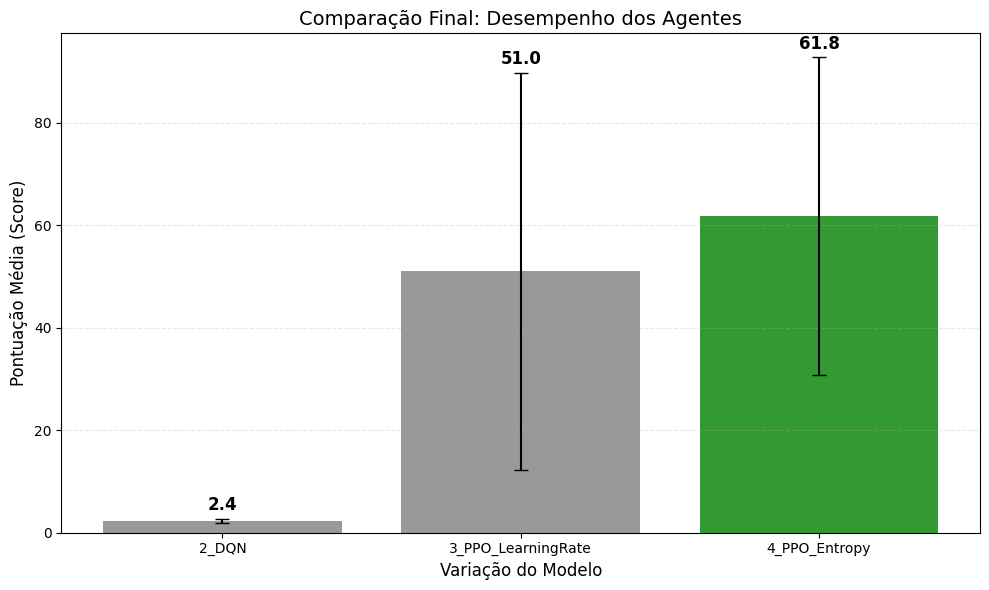

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carrega os dados direto do arquivo que foi salvo
# Isso garante que os números sejam EXATAMENTE os do seu teste
df = pd.read_csv("resultados_finais_relatorio.csv")

renomear = {
    'mean_reward': 'Recompensa Média',  # Caso venha minúsculo
    'Mean_Reward': 'Recompensa Média',  # Caso venha Maiúsculo
    'std_reward': 'Desvio Padrão',
    'Std_Reward': 'Desvio Padrão',
    'id': 'Experimento',       
    'Model': 'Experimento'    
}

df = df.rename(columns=renomear)

# (Opcional) Vamos ordenar do menor para o maior score para ficar bonito
df = df.sort_values(by="Recompensa Média", ascending=True)

print("Dados carregados do arquivo:")
print(df)

# 2. Configura o Gráfico
plt.figure(figsize=(10, 6))

# Truque visual: Vamos pintar a barra do Vencedor de verde e as outras de cinza
# Identifica o valor máximo
max_score = df['Recompensa Média'].max()
cores = ['green' if x == max_score else 'gray' for x in df['Recompensa Média']]

# Cria as barras
# x = Nome do Experimento
# y = Recompensa Média
# yerr = Desvio Padrão (a linha preta de variação)
bars = plt.bar(df['Experimento'], df['Recompensa Média'],
               yerr=df['Desvio Padrão'], capsize=5,
               color=cores, alpha=0.8)

# 3. Formatação
plt.bar_label(bars, fmt='%.1f', padding=3, fontsize=12, fontweight='bold')
plt.title('Comparação Final: Desempenho dos Agentes', fontsize=14)
plt.ylabel('Pontuação Média (Score)', fontsize=12)
plt.xlabel('Variação do Modelo', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Salva e mostra
plt.tight_layout()
plt.savefig("grafico_oficial_relatorio.png", dpi=300) # dpi=300 deixa alta resolução pro PDF
plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# --- CONFIGURAÇÃO ---
LOG_DIR = "./relatorio_logs"  # A pasta onde seus logs estão
OUTPUT_DIR = "./graficos_finais" # Onde vamos salvar as imagens

os.makedirs(OUTPUT_DIR, exist_ok=True)

def extrair_dados(log_dir):
    """Lê todos os logs e organiza por Tag (métrica)"""
    dados_agrupados = {} # Dicionário: {'nome_metrica': { 'exp1': (steps, vals), 'exp2': ... } }

    # Varre as pastas de experimentos
    for pasta_exp in os.listdir(log_dir):
        caminho_completo = os.path.join(log_dir, pasta_exp)

        if os.path.isdir(caminho_completo):
            # Encontra o arquivo de eventos do Tensorboard
            arquivos_evento = [f for f in os.listdir(caminho_completo) if "tfevents" in f]
            if not arquivos_evento:
                continue

            path_arquivo = os.path.join(caminho_completo, arquivos_evento[0])

            # Carrega os dados
            ea = EventAccumulator(path_arquivo)
            ea.Reload()

            # Pega todas as métricas disponíveis (scalars)
            tags = ea.Tags()['scalars']

            for tag in tags:
                if tag not in dados_agrupados:
                    dados_agrupados[tag] = {}

                # Extrai passos e valores
                eventos = ea.Scalars(tag)
                steps = [e.step for e in eventos]
                values = [e.value for e in eventos]

                dados_agrupados[tag][pasta_exp] = (steps, values)

    return dados_agrupados

print("Extraindo dados do Tensorboard... (Isso pode levar alguns segundos)")
todos_dados = extrair_dados(LOG_DIR)

print(f"Encontradas {len(todos_dados)} métricas diferentes.")

# --- GERAR GRÁFICOS ---
for tag, experimentos in todos_dados.items():
    plt.figure(figsize=(10, 6))

    # Plota uma linha para cada experimento que tem essa métrica
    for nome_exp, (steps, values) in experimentos.items():
        #series_suavizada = pd.Series(values).rolling(window=50).mean() # Suaviza a linha
        #plt.plot(steps, series_suavizada, label=nome_exp)
        plt.plot(steps, values, label=nome_exp, alpha=0.8)

    # Formatação bonita para relatório
    nome_limpo = tag.replace("rollout/", "").replace("train/", "").replace("/", "_")
    plt.title(f"Comparativo: {tag}")
    plt.xlabel("Passos (Steps)")
    plt.ylabel("Valor")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    # Salva
    nome_arquivo = os.path.join(OUTPUT_DIR, f"{nome_limpo}.png")
    plt.savefig(nome_arquivo, dpi=150)
    plt.close() # Fecha para não consumir memória
    print(f"Salvo: {nome_arquivo}")

print("\n--- PROCESSO CONCLUÍDO ---")

Extraindo dados do Tensorboard... (Isso pode levar alguns segundos)
Encontradas 13 métricas diferentes.
Salvo: ./graficos_finais\ep_len_mean.png
Salvo: ./graficos_finais\ep_rew_mean.png
Salvo: ./graficos_finais\exploration_rate.png
Salvo: ./graficos_finais\time_fps.png
Salvo: ./graficos_finais\learning_rate.png
Salvo: ./graficos_finais\loss.png
Salvo: ./graficos_finais\approx_kl.png
Salvo: ./graficos_finais\clip_fraction.png
Salvo: ./graficos_finais\clip_range.png
Salvo: ./graficos_finais\entropy_loss.png
Salvo: ./graficos_finais\explained_variance.png
Salvo: ./graficos_finais\policy_gradient_loss.png
Salvo: ./graficos_finais\value_loss.png

--- PROCESSO CONCLUÍDO ---


In [ ]:
# colab
# import shutil
# from google.colab import files

# # Cria o zip
# shutil.make_archive('graficos_relatorio', 'zip', './graficos_finais')

# # Baixa para o seu PC
# files.download('graficos_relatorio.zip')

In [ ]:
#colab
# import shutil
# from google.colab import files

# # Cria um zip com TUDO o que foi gerado
# shutil.make_archive('backup_completo_trabalho', 'zip', './')
# print("Backup criado! Baixando...")
# files.download('backup_completo_trabalho.zip')

In [ ]:
import shutil
import os
import glob
import stat  # Necessário para mudar permissões de arquivo

print("📦 Compactando de forma otimizada (excluindo .ipynb, .git e Zips antigos)...")

# --- FUNÇÃO AUXILIAR PARA FORÇAR DELEÇÃO NO WINDOWS ---
def remove_readonly(func, path, _):
    """
    Callback para remover arquivos somente leitura (comum em pastas .git)
    que causam PermissionError no Windows.
    """
    os.chmod(path, stat.S_IWRITE)
    func(path)

# --- 1. CONFIGURAÇÃO E NOME ÚNICO ---
nome_base = 'RELATORIO_FINAL_COMPLETO'
nome_final_zip = nome_base
contador = 1
PASTA_STAGE = "backup_stage_temp"

# Remove pasta temporária anterior, se existir (usando o fix de permissão)
if os.path.exists(PASTA_STAGE):
    shutil.rmtree(PASTA_STAGE, onerror=remove_readonly)
    
os.makedirs(PASTA_STAGE, exist_ok=True)

# Encontra nome único (RELATORIO_FINAL_COMPLETO (n))
while os.path.exists(f"{nome_final_zip}.zip"):
    nome_final_zip = f"{nome_base} ({contador})"
    contador += 1

# --- 2. LISTA E FILTRA ITENS DA PASTA RAIZ ---
todos_os_itens = os.listdir('.')
itens_para_copiar = []

exclusoes = [
    '__pycache__',
    '.git',                        # <--- ADICIONADO: Remove o peso do Git
    '.gitattributes',
    '.gitignore',
    PASTA_STAGE,
]

# Critério de exclusão
def deve_excluir(item):
    # Exclui arquivos .ipynb
    if item.endswith('.ipynb'):
        return True
    # Exclui zips de backup que começam com o nome de relatório
    if item.endswith('.zip') and item.startswith('RELATORIO_FINAL_COMPLETO'):
        return True
    # Exclui pastas e arquivos temporários da lista
    if item in exclusoes:
        return True
    return False

# Aplica o filtro
for item in todos_os_itens:
    if not deve_excluir(item):
        itens_para_copiar.append(item)

# --- 3. COPIA OS ARQUIVOS FILTRADOS PARA O STAGE ---
print(f"Copiando {len(itens_para_copiar)} itens para a área de stage...")
for item in itens_para_copiar:
    caminho_origem = os.path.join('.', item)
    destino = os.path.join(PASTA_STAGE, os.path.basename(item))
    
    # Tratamento para copiar (evita erro se tentar copiar arquivo aberto)
    try:
        if os.path.isdir(caminho_origem):
            shutil.copytree(caminho_origem, destino, dirs_exist_ok=True)
        else:
            shutil.copy2(caminho_origem, destino)
    except PermissionError as e:
        print(f"⚠️ Aviso: Não foi possível copiar '{item}'. Motivo: {e}")

# --- 4. CRIAÇÃO DO ZIP A PARTIR DO STAGE ---
print(f"Compactando o stage como '{nome_final_zip}'.")

shutil.make_archive(
    base_name=nome_final_zip, 
    format='zip', 
    root_dir=PASTA_STAGE, 
    base_dir='.'
)

# --- 5. LIMPEZA FINAL ---
# Usa o onerror=remove_readonly para garantir que apague tudo sem travar
shutil.rmtree(PASTA_STAGE, onerror=remove_readonly)

print(f"✅ SUCESSO! O arquivo final '{nome_final_zip}.zip' foi criado.")
print("Ao abrir o arquivo, você verá as pastas de logs/modelos e os CSVs na raiz.")

📦 Compactando de forma otimizada (excluindo .ipynb, .git e Zips antigos)...
Copiando 8 itens para a área de stage...
Compactando o stage como 'RELATORIO_FINAL_COMPLETO (1)'.
✅ SUCESSO! O arquivo final 'RELATORIO_FINAL_COMPLETO (1).zip' foi criado.
Ao abrir o arquivo, você verá as pastas de logs/modelos e os CSVs na raiz.
